In [1]:
# we are gonna open 'big_bebop_data.pickle'
# and train a neural network on to model the forces and moments

import pickle
import numpy as np
import matplotlib.pyplot as plt

# open the pickle file
pickle_in = open('datasets/aug_bebop_data.pickle', 'rb')
data = pickle.load(pickle_in)

## Prepocess data

In [2]:
# add filtered accelerometer and gyro data
from scipy import signal

delete = []

for key in data.keys():
    t = data[key]['t']
    if len(t) < 4000:
        delete.append(key)
        print('not using', key, 'because it has less than 1000 data points')
    else:
        dt = np.mean(np.gradient(t))
        freq = 1/dt
        cutoff_freq = 16 #Hz
        sos = signal.butter(2, cutoff_freq, fs=freq, output='sos')

        var = ['w1','w2','w3','w4','ax','ay','az','p','q','r','vbx','vby','vbz']
        w1,w2,w3,w4,ax,ay,az,p,q,r,vbx,vby,vbz = [data[key][v] for v in var]

        data[key]['ax_filt'] = signal.sosfiltfilt(sos, ax)
        data[key]['ay_filt'] = signal.sosfiltfilt(sos, ay)
        data[key]['az_filt'] = signal.sosfiltfilt(sos, az)
            
        p_ = signal.sosfiltfilt(sos, p)
        q_ = signal.sosfiltfilt(sos, q)
        r_ = signal.sosfiltfilt(sos, r)

        w1_ = signal.sosfiltfilt(sos, w1)
        w2_ = signal.sosfiltfilt(sos, w2)
        w3_ = signal.sosfiltfilt(sos, w3)
        w4_ = signal.sosfiltfilt(sos, w4)

        data[key]['p_filt'] = p_
        data[key]['q_filt'] = q_
        data[key]['r_filt'] = r_

        d_p = np.gradient(p_)/np.gradient(t)
        d_q = np.gradient(q_)/np.gradient(t)
        d_r = np.gradient(r_)/np.gradient(t)
        
        d_w1 = np.gradient(w1_)/np.gradient(t)
        d_w2 = np.gradient(w2_)/np.gradient(t)
        d_w3 = np.gradient(w3_)/np.gradient(t)
        d_w4 = np.gradient(w4_)/np.gradient(t)

        # parameters from https://arxiv.org/pdf/2304.13460.pdf
        k_x  = 1.07933887e-05
        k_y  = 9.65250793e-06
        k_z  = 2.7862899e-05
        k_w  = 4.36301076e-08
        k_h  = 0.0625501332

        Ix = 0.000906
        Iy = 0.001242
        Iz = 0.002054

        k_p  = 1.4119331e-09
        k_pv = -0.00797101848
        k_q  = 1.21601884e-09
        k_qv = 0.0129263739
        k_r1 = 2.57035545e-06
        k_r2 = 4.10923364e-07
        k_rr = 0.000812932607

        data[key]['ax_mod'] = -k_x*vbx*(w1+w2+w3+w4)
        data[key]['ay_mod'] = -k_y*vby*(w1+w2+w3+w4)
        data[key]['az_mod'] = -k_w*(w1**2+w2**2+w3**2+w4**2) - k_z*vbz*(w1+w2+w3+w4) - k_h*(vbx**2+vby**2)

        # Residual accelerations
        data[key]['ax_res'] = data[key]['ax_filt'] - data[key]['ax_mod']
        data[key]['ay_res'] = data[key]['ay_filt'] - data[key]['ay_mod']
        data[key]['az_res'] = data[key]['az_filt'] - data[key]['az_mod']

        Mx = Ix*d_p+(Iz-Iy)*q_*r_
        My = Iy*d_q+(Ix-Iz)*p_*r_
        Mz = Iz*d_r+(Iy-Ix)*p_*q_

        data[key]['dp_dt'] = d_p
        data[key]['dq_dt'] = d_q
        data[key]['dr_dt'] = d_r

        data[key]['Mx'] = Mx
        data[key]['My'] = My
        data[key]['Mz'] = Mz

        data[key]['Mx_mod'] = k_p*(w1**2-w2**2-w3**2+w4**2) + k_pv*vby
        data[key]['My_mod'] = k_q*(w1**2+w2**2-w3**2-w4**2) + k_qv*vbx
        data[key]['Mz_mod'] = k_r1*(-w1+w2-w3+w4) + k_r2*(-d_w1+d_w2-d_w3+d_w4)+k_rr*(-r)

        # Residual moments
        data[key]['Mx_res'] = data[key]['Mx'] - data[key]['Mx_mod']
        data[key]['My_res'] = data[key]['My'] - data[key]['My_mod']
        data[key]['Mz_res'] = data[key]['Mz'] - data[key]['Mz_mod']

        # normalized rpms
        data[key]['w1n'] = 2*(data[key]['w1'] - 3000)/(12000-3000) - 1
        data[key]['w2n'] = 2*(data[key]['w2'] - 3000)/(12000-3000) - 1
        data[key]['w3n'] = 2*(data[key]['w3'] - 3000)/(12000-3000) - 1
        data[key]['w4n'] = 2*(data[key]['w4'] - 3000)/(12000-3000) - 1

        # normalized rpm commands
        data[key]['u1n'] = 2*(data[key]['u1'] - 3000)/(12000-3000) - 1
        data[key]['u2n'] = 2*(data[key]['u2'] - 3000)/(12000-3000) - 1
        data[key]['u3n'] = 2*(data[key]['u3'] - 3000)/(12000-3000) - 1
        data[key]['u4n'] = 2*(data[key]['u4'] - 3000)/(12000-3000) - 1

for key in delete:
    data.pop(key)

not using flight_data/10aug/low_freq_dist_input.csv_0 because it has less than 1000 data points
not using flight_data/10aug/low_freq_dist.csv_0 because it has less than 1000 data points
not using flight_data/2aug/20230802-135724.csv_0 because it has less than 1000 data points
not using flight_data/8aug/modifiedEKF.csv_0 because it has less than 1000 data points
not using flight_data/8aug/fixed_yaw_normalize.csv_0 because it has less than 1000 data points
not using flight_data/12aug/bigger_repeat.csv_0 because it has less than 1000 data points


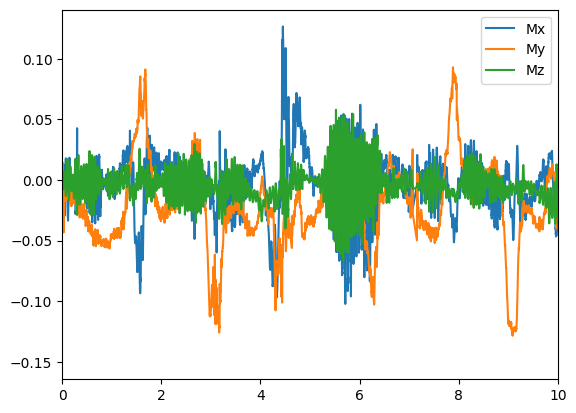

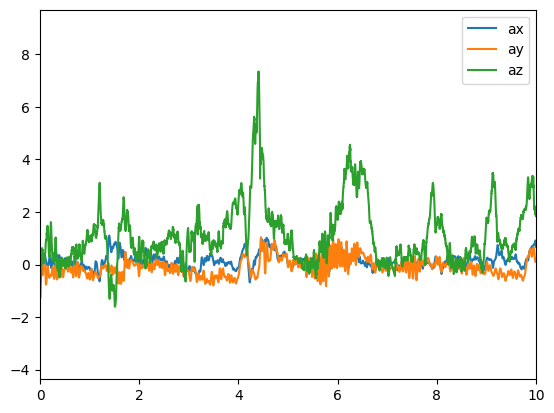

In [3]:
trajectories = list(data.keys())
traj = trajectories[np.random.randint(0, len(trajectories))]
t = data[traj]['t']-data[traj]['t'][0]
Mx_res = data[traj]['Mx_res']
My_res = data[traj]['My_res']
Mz_res = data[traj]['Mz_res']
ax_res = data[traj]['ax_res']
ay_res = data[traj]['ay_res']
az_res = data[traj]['az_res']

plt.plot(t, Mx_res, label='Mx')
plt.plot(t, My_res, label='My')
plt.plot(t, Mz_res, label='Mz')
plt.xlim([0, 10])
plt.legend()
plt.show()

plt.plot(t, ax_res, label='ax')
plt.plot(t, ay_res, label='ay')
plt.plot(t, az_res, label='az')
plt.xlim([0, 10])
plt.legend()

## Create the Datasets

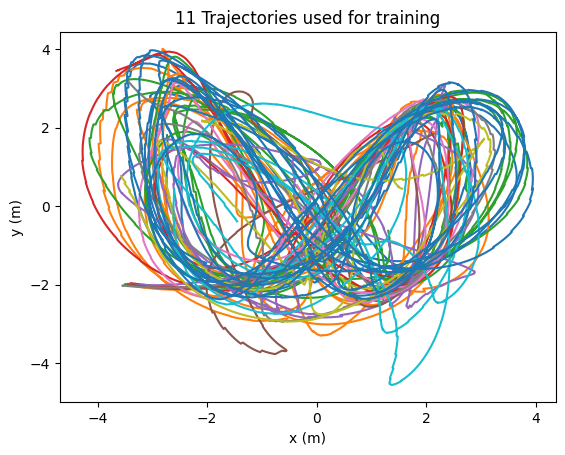

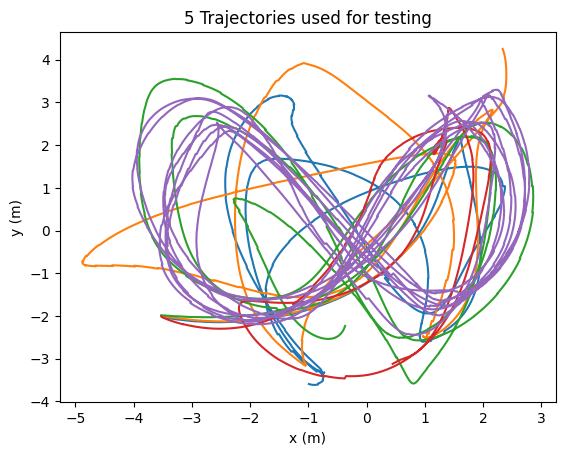

In [4]:
trajectories = list(data.keys())

# we will use the first 70% of the trajectories for training and the last 30% for testing
train_indices = np.random.choice(len(trajectories), int(len(trajectories)*0.7), replace=False)
train_trajectories = np.array(trajectories)[train_indices]
test_indices = np.array([i for i in range(len(trajectories)) if i not in train_indices])
test_trajectories = np.array(trajectories)[test_indices]

for traj in train_trajectories:
    plt.plot(data[traj]['x'], data[traj]['y'])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{len(train_trajectories)} Trajectories used for training')
plt.show()

for traj in test_trajectories:
    plt.plot(data[traj]['x'], data[traj]['y'])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{len(test_trajectories)} Trajectories used for testing')
plt.show()

## Dataloader

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class TrajectoryDataset(Dataset):
    def __init__(self, trajectories, input_keys, output_keys, normalize=False):
        self.trajectories = trajectories
        # length of each trajectory
        self.lenghts = [len(data[traj]['t']) for traj in trajectories]
        # cumulative sum of lengths
        self.lengths_cum_sum = np.cumsum(self.lenghts)
        # total length of all trajectories added together
        self.total_len = sum(self.lenghts)
        self.input_keys = input_keys
        self.output_keys = output_keys
        # normalization
        self.normalize = False
        X_mean, X_std, Y_mean, Y_std = self.get_mean_and_std()
        self.normalize = normalize
        self.X_mean = X_mean
        self.X_std = X_std
        self.Y_mean = Y_mean
        self.Y_std = Y_std


    def __getitem__(self, index):
        # determine which trajectory the index belongs to
        traj = ''
        traj_i = 0
        for i, l in enumerate(self.lengths_cum_sum):
            if index < l:
                traj = self.trajectories[i]
                if i == 0:
                    traj_i = index
                else:
                    traj_i = index - self.lengths_cum_sum[i-1]
                traj_data = data[traj]
                # get the data for the trajectory
                X = torch.zeros((len(self.input_keys)))
                for i, key in enumerate(self.input_keys):
                    X[i] = traj_data[key][traj_i]
                Y = torch.zeros((len(self.output_keys)))
                for i, key in enumerate(self.output_keys):
                    Y[i] = traj_data[key][traj_i]
                if self.normalize:
                    X = (X - self.X_mean) / self.X_std
                    Y = (Y - self.Y_mean) / self.Y_std
                return X, Y

    def __len__(self):
        return self.total_len
    
    def get_mean_and_std(self, num_samples=1000):
        # get a random sample of num_samples from the dataset
        sample = np.random.choice(self.total_len, num_samples)
        # get the input and output data
        X = torch.zeros((num_samples, len(self.input_keys)))
        Y = torch.zeros((num_samples, len(self.output_keys)))
        for i, index in enumerate(sample):
            X[i], Y[i] = self.__getitem__(index)
        # calculate the mean and std
        X_mean = torch.mean(X, dim=0)
        X_std = torch.std(X, dim=0)

        Y_mean = torch.mean(Y, dim=0)
        Y_std = torch.std(Y, dim=0)
        return X_mean, X_std, Y_mean, Y_std

## Training loop

In [6]:
# Training loop
from tqdm import tqdm
import torch.nn as nn

def training_loop(model, train_loader, test_loader, num_epochs=10, lr=1e-3):
    # Define the loss function
    loss_fn = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Loop over epochs
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        train_loss = 0
        for i, (inputs, outputs) in loop:
            # Compute the model output
            preds = model(inputs)

            # Compute the loss
            loss = loss_fn(preds, outputs)
            train_loss += loss.item()

            # Compute the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Reset the gradients
            optimizer.zero_grad()
            # Update progressbar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        # Evaluate the model
        vali_loss = 0
        with torch.no_grad():
            loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
            for i, (inputs, outputs) in loop:
                # Compute the model output
                preds = model(inputs)

                # Compute the loss
                loss = loss_fn(preds, outputs)
                vali_loss += loss.item()
                # Update progressbar
                loop.set_postfix(loss=loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}] train_loss: {train_loss/len(train_loader)} vali_loss: {vali_loss/len(test_loader)}")

## Thrust model

In [7]:
# model that calculates the specific forces from the (normalized) rpm commands and body velocities
input_keys = ['w1n', 'w2n', 'w3n', 'w4n', 'vbx', 'vby', 'vbz']
output_keys = ['az_res']

# Load the dataset
train_dataset = TrajectoryDataset(train_trajectories, input_keys, output_keys)
test_dataset = TrajectoryDataset(test_trajectories, input_keys, output_keys)

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Create the model
forces_model = nn.Sequential(
    nn.Linear(len(input_keys), 32),
    nn.ReLU(),
    nn.Linear(32, len(output_keys))
)

# Train
# training_loop(forces_model, train_loader, test_loader, num_epochs=20)

flight_data/2aug/20230802-140035.csv_0


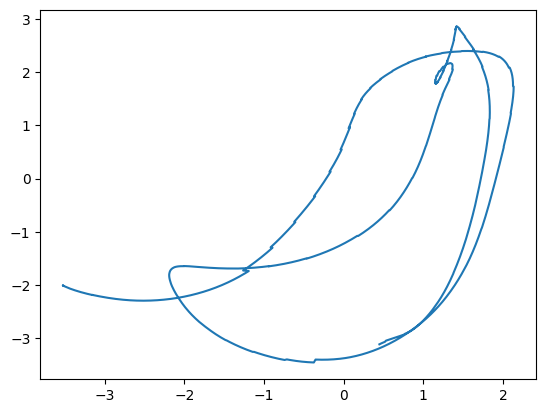

(0.0, 10.0)

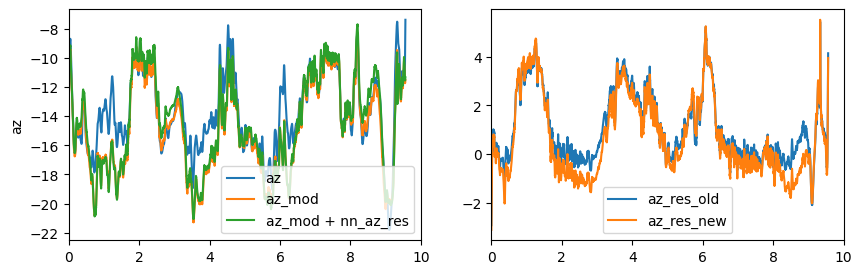

In [8]:
test_traj = list(test_trajectories)[np.random.randint(0, len(test_trajectories))]
print(test_traj)

t = data[test_traj]['t']
t -= t[0]

nn_input = np.stack([data[test_traj][key] for key in input_keys], axis=1)
nn_input = torch.tensor(nn_input, dtype=torch.float32)
nn_output = forces_model(nn_input).detach().numpy()

plt.plot(data[test_traj]['x'], data[test_traj]['y'])
plt.show()

# 1x2 subplots 
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
xlim = [0,10]
axs[0].plot(t, data[test_traj]['az_filt'], label='az')
axs[0].plot(t, data[test_traj]['az_mod'], label='az_mod')
axs[0].plot(t, data[test_traj]['az_mod']+nn_output[:, 0], label='az_mod + nn_az_res')
axs[0].set_ylabel('az')
axs[0].legend()
axs[0].set_xlim(xlim)

axs[1].plot(t, data[test_traj]['az_filt']-data[test_traj]['az_mod'], label='az_res_old')
axs[1].plot(t, data[test_traj]['az_filt']-data[test_traj]['az_mod']-nn_output[:, 0], label='az_res_new')
axs[1].legend()
axs[1].set_xlim(xlim)

## Moment model

In [9]:
# model that calculates the angular acceleration from the (normalized) rpm commands, body velocities and angular velocities
input_keys = ['w1n', 'w2n', 'w3n', 'w4n', 'vbx', 'vby', 'vbz', 'p', 'q', 'r']
output_keys = ['Mx_res', 'My_res', 'Mz_res']

# Load the dataset
train_dataset = TrajectoryDataset(train_trajectories, input_keys, output_keys, normalize=False)
test_dataset = TrajectoryDataset(test_trajectories, input_keys, output_keys, normalize=False)

# Calculate the mean and std of the dataset (from N samples)
input_mean, input_std, output_mean, output_std = train_dataset.get_mean_and_std(100000)
print('Input: mean = {}, std = {}'.format(input_mean, input_std))
print('Output: mean = {}, std = {}'.format(output_mean, output_std))

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Create the model
moment_model = nn.Sequential(
    nn.Linear(len(input_keys), 32),
    nn.ReLU(),
    nn.Linear(32, len(output_keys)),
)

# Train
# training_loop(moment_model, train_loader, test_loader, num_epochs=20)

Input: mean = tensor([ 0.3574,  0.4715,  0.2773,  0.4339,  0.4511,  0.3922, -0.6274, -0.0931,
         0.0028, -0.3091]), std = tensor([0.2623, 0.2298, 0.2721, 0.2585, 2.7707, 2.9007, 1.9698, 1.8531, 2.1408,
        0.7129])
Output: mean = tensor([-0.0014, -0.0171, -0.0035]), std = tensor([0.0230, 0.0336, 0.0115])


flight_data/12aug/bigger2.csv_1


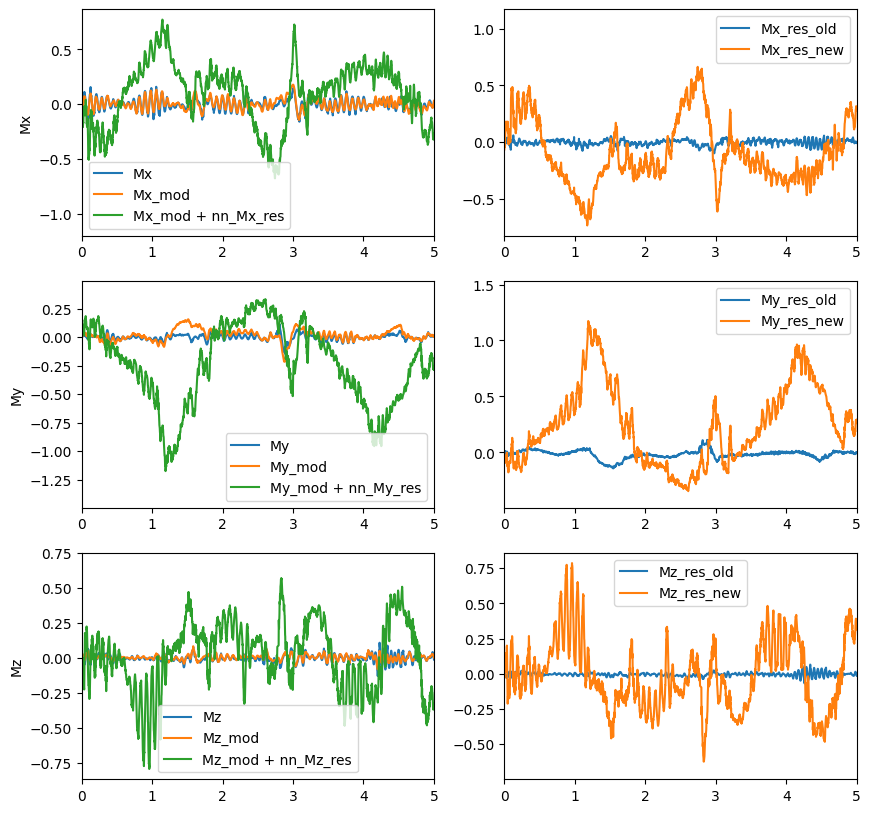

In [10]:
test_traj = list(test_trajectories)[np.random.randint(0, len(test_trajectories))]

print(test_traj)
t = data[test_traj]['t']
t -= t[0]

nn_input = np.stack([data[test_traj][key] for key in input_keys], axis=1)
nn_input = torch.tensor(nn_input, dtype=torch.float32)
nn_output = moment_model(nn_input).detach().numpy()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
xlim = [0, 5]
axs[0, 0].plot(t, data[test_traj]['Mx'], label='Mx')
axs[0, 0].plot(t, data[test_traj]['Mx_mod'], label='Mx_mod')
axs[0, 0].plot(t, data[test_traj]['Mx_mod']+nn_output[:, 0], label='Mx_mod + nn_Mx_res')
axs[0, 0].set_ylabel('Mx')
axs[0, 0].legend()
axs[0, 0].set_xlim(xlim)

axs[0, 1].plot(t, data[test_traj]['Mx']-data[test_traj]['Mx_mod'], label='Mx_res_old')
axs[0, 1].plot(t, data[test_traj]['Mx']-data[test_traj]['Mx_mod']-nn_output[:, 0], label='Mx_res_new')
axs[0, 1].legend()
axs[0, 1].set_xlim(xlim)

axs[1, 0].plot(t, data[test_traj]['My'], label='My')
axs[1, 0].plot(t, data[test_traj]['My_mod'], label='My_mod')
axs[1, 0].plot(t, data[test_traj]['My_mod']+nn_output[:, 1], label='My_mod + nn_My_res')
axs[1, 0].set_ylabel('My')
axs[1, 0].legend()
axs[1, 0].set_xlim(xlim)

axs[1, 1].plot(t, data[test_traj]['My']-data[test_traj]['My_mod'], label='My_res_old')
axs[1, 1].plot(t, data[test_traj]['My']-data[test_traj]['My_mod']-nn_output[:, 1], label='My_res_new')
axs[1, 1].legend()
axs[1, 1].set_xlim(xlim)

axs[2, 0].plot(t, data[test_traj]['Mz'], label='Mz')
axs[2, 0].plot(t, data[test_traj]['Mz_mod'], label='Mz_mod')
axs[2, 0].plot(t, data[test_traj]['Mz_mod']+nn_output[:, 2], label='Mz_mod + nn_Mz_res')
axs[2, 0].set_ylabel('Mz')
axs[2, 0].legend()
axs[2, 0].set_xlim(xlim)

axs[2, 1].plot(t, data[test_traj]['Mz']-data[test_traj]['Mz_mod'], label='Mz_res_old')
axs[2, 1].plot(t, data[test_traj]['Mz']-data[test_traj]['Mz_mod']-nn_output[:, 2], label='Mz_res_new')
axs[2, 1].legend()
axs[2, 1].set_xlim(xlim)

plt.show()

In [11]:
import os

# save the models in the folder: quad_RL/NNDroneModel
if not os.path.exists('NNDroneModel'):
    os.makedirs('NNDroneModel')

thrust_model = forces_model
moment_model = moment_model

# save the models
# torch.save(thrust_model, 'NNDroneModel/thrust_model.pt')
# torch.save(moment_model, 'NNDroneModel/moment_model.pt')

# Plots for paper

In [12]:
# load thrust and moment model from NNDroneModel
thrust_model = torch.load('NNDroneModel/thrust_model.pt')
moment_model = torch.load('NNDroneModel/moment_model.pt')

moment_input_keys = ['w1n', 'w2n', 'w3n', 'w4n', 'vbx', 'vby', 'vbz', 'p', 'q', 'r']
moment_output_keys = ['Mx_res', 'My_res', 'Mz_res']

thrust_input_keys = ['w1n', 'w2n', 'w3n', 'w4n', 'vbx', 'vby', 'vbz']
thurst_output_keys = ['az_res']


/tmp/ipykernel_3628/2346786030.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


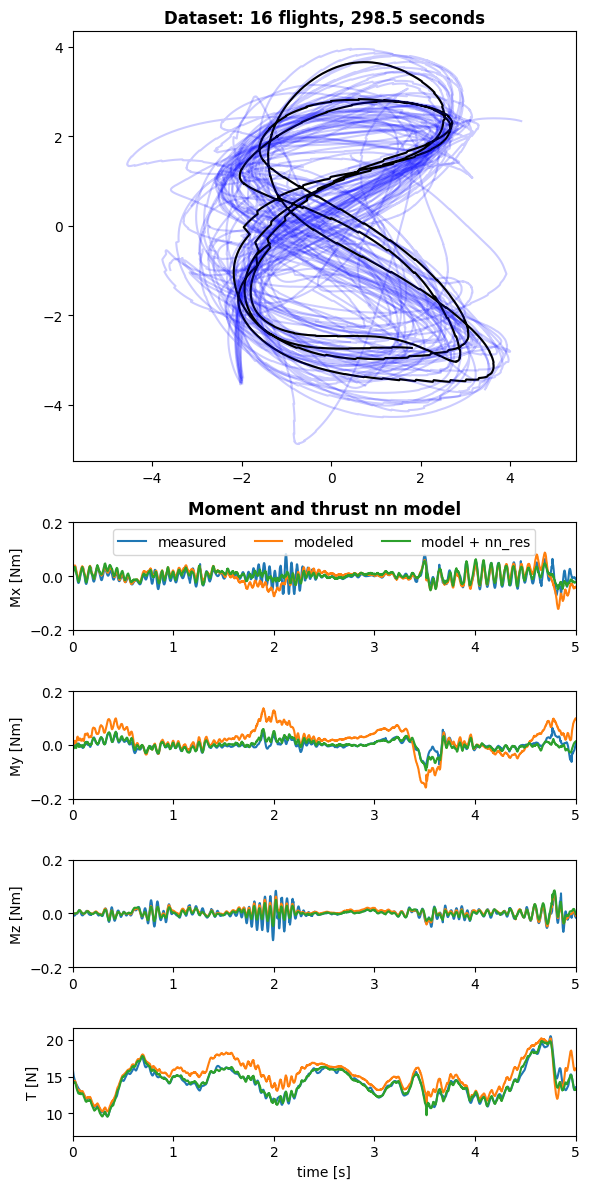

In [26]:
# pick random flight
flight = list(data.keys())[np.random.randint(0, len(data.keys()))]

moment_input = np.stack([data[flight][key] for key in moment_input_keys], axis=1)
moment_input = torch.tensor(moment_input, dtype=torch.float32)
moment_output = moment_model(moment_input).detach().numpy()

thurst_input = np.stack([data[flight][key] for key in thrust_input_keys], axis=1)
thurst_input = torch.tensor(thurst_input, dtype=torch.float32)
thurst_output = thrust_model(thurst_input).detach().numpy()

# 4x1 subplots with one subplot on the left and 3 subplots on the right  (A, B, C share y axis)
# fig, axs = plt.subplot_mosaic("AB;AC;AD;AE", figsize=(12, 6), tight_layout=True)
fig, axs = plt.subplots(5,1, figsize=(6, 12), tight_layout=True, gridspec_kw={'height_ratios': [4, 1, 1, 1, 1]})

plt.sca(axs[0])
total_time = 0
for f in data.keys():
    plt.plot(data[f]['y'], data[f]['x'], alpha=0.2, color='b')
    if f==flight:
        plt.plot(data[f]['y'], data[f]['x'], alpha=1, color='black')
    total_time += data[flight]['t'][-1]-data[flight]['t'][0]
# title: dataset
plt.title(f'Dataset: {len(data.keys())} flights, {total_time:.1f} seconds', fontweight='bold')
plt.axis('equal')

xlim = [0,5]
ylim = [-.2,.2]
plt.sca(axs[1])
plt.plot(data[flight]['t'], data[flight]['Mx'], label='measured')
plt.plot(data[flight]['t'], data[flight]['Mx_mod'], label='modeled')
plt.plot(data[flight]['t'], data[flight]['Mx_mod']+moment_output[:, 0], label='model + nn_res')
plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('Mx [Nm]')
# legend on top
plt.legend(loc='upper center', ncol=3)
plt.title('Moment and thrust nn model', fontweight='bold')

plt.sca(axs[2])
plt.plot(data[flight]['t'], data[flight]['My'], label='measured')
plt.plot(data[flight]['t'], data[flight]['My_mod'], label='My_mod')
plt.plot(data[flight]['t'], data[flight]['My_mod']+moment_output[:, 1], label='model + nn_res')
plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('My [Nm]')

plt.sca(axs[3])
plt.plot(data[flight]['t'], data[flight]['Mz'], label='measured')
plt.plot(data[flight]['t'], data[flight]['Mz_mod'], label='modeled')
plt.plot(data[flight]['t'], data[flight]['Mz_mod']+moment_output[:, 2], label='model + nn_res')
plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('Mz [Nm]')

plt.sca(axs[4])
plt.plot(data[flight]['t'], -data[flight]['az_filt'], label='measured')
plt.plot(data[flight]['t'], -data[flight]['az_mod'], label='modeled')
plt.plot(data[flight]['t'], -data[flight]['az_mod']-thurst_output[:, 0], label='model + nn_res')
plt.xlim(xlim)
plt.xlabel('time [s]')
plt.ylabel('T [N]')
# save figure
plt.savefig('Figures/nn_model.pdf')
fig.show()
